# JOSS 2025 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/joss/demos/talk_paper_demos/JOSS2025/joss2025.ipynb)

## Setup

In [ ]:
try:
    import qmcpy 
except ImportError:
    !pip install -q qmcpy==2.0
import os

In [2]:
dpi = 900  # output .png image resolution

In [3]:
import matplotlib 
matplotlib.rcParams['figure.dpi'] = dpi
from matplotlib import pyplot 
import seaborn as sns
from tueplots import bundles
pyplot.rcParams.update(bundles.probnum2025())
COLORS = ['xkcd:purple', 'xkcd:green', 'xkcd:blue', 'xkcd:orange']
MARKERS = ["*","^","o","s"]
MARKERSIZE = 5
OUTDIR = "JOSS2025.outputs"
FIGWIDTH = 500/72
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

## Listings

### Example 1: QMCPy Version

First, we verify the installed version of QMCPy:

In [4]:
import qmcpy as qp 
qp.__version__

'2.0'

### Example 2: Generating Randomized LD Sequences

The following code generates the first $2^7$ points from a $d=2$ dimensional digital net randomized with a linear matrix scramble (LMS) and digital shift (DS). The output shows the shape of the generated points array.

In [5]:
dnb2 = qp.DigitalNetB2(dimension=2, randomize="LMS_DS")
x = dnb2(2**7)
x.shape


(128, 2)

### Example 3: Multiple Replications

QMCPy supports simultaneously generating multiple randomizations of a single LD sequence. The following code generates 5 independently randomized digital nets. The output shape shows (replications, samples, dimensions).

In [6]:
dnb2 = qp.DigitalNetB2(dimension=2, replications=5, randomize="LMS_DS")
x = dnb2(2**7)
x.shape

(5, 128, 2)

### Example 4: QMC Error Estimation for Asian Option Pricing

In this example, we estimate the fair price of an Asian call option with monthly monitoring for one year. The LD sequence is used to construct a sampler for the Asian option payoffs which is used by the QMC stopping criterion. The stopping criterion's `integrate` method deploys adaptive QMC cubature.

In [7]:
dnb2 = qp.DigitalNetB2( # special case of a digital net
    dimension = 12, # monthly monitoring 
    seed = 7, # for reproducibility
)
asian_option = qp.FinancialOption(
    sampler = dnb2 ,
    option = "ASIAN",
    call_put = "CALL",
    asian_mean = "GEOMETRIC",
    asian_mean_quadrature_rule = "RIGHT", 
    volatility = 0.5, 
    start_price = 30., 
    strike_price = 35., 
    interest_rate = 0.01, # 1% interest rate
    t_final = 1, # 1 year 
)
qmc_algorithm = qp.CubQMCNetG(
    integrand = asian_option,
    abs_tol = 1e-3,
    rel_tol = 0,
    n_init = 2**8,
)
est,data = qmc_algorithm.integrate()
est
data

array(1.7665677)

Data (Data)
    solution        1.767
    comb_bound_low  1.766
    comb_bound_high 1.767
    comb_bound_diff 0.002
    comb_flags      1
    n_total         2^(15)
    n               2^(15)
    time_integrate  0.016
CubQMCNetG (AbstractStoppingCriterion)
    abs_tol         0.001
    rel_tol         0
    n_init          2^(8)
    n_limit         2^(35)
FinancialOption (AbstractIntegrand)
    option          ASIAN
    call_put        CALL
    volatility      2^(-1)
    start_price     30
    strike_price    35
    interest_rate   0.010
    t_final         1
    asian_mean      GEOMETRIC
BrownianMotion (AbstractTrueMeasure)
    time_vec        [0.083 0.167 0.25  ... 0.833 0.917 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.083 0.083 0.083 ... 0.083 0.083 0.083]
                     [0.083 0.167 0.167 ... 0.167 0.167 0.167]
                     [0.083 0.167 0.25  ... 0.25  0.25  0.25 ]
                     ...
                     [0.0

The QMC algorithm estimates the fair price of the option to approximately $\$1.767$ with a guaranteed error bound of $\pm \$0.001$ (one-tenth of a cent). This result was achieved using $n = 2^{15} = 32{,}768$ samples from a randomized digital net in less than $0.02$ seconds. The algorithm automatically determines the sample size needed to meet the specified absolute error tolerance of $10^{-3}$.

### Example 5: User-Defined Problems - Borehole Function

Here we implement the [Borehole function](https://www.sfu.ca/~ssurjano/borehole.html) as detailed in the [Virtual Library of Simulation Experiments](https://www.sfu.ca/~ssurjano/index.html). The list of independent marginal distributions from `scipy.stats` is passed into `qp.SciPyWrapper` along with the low-discrepancy lattice point generator. The Python function `borehole` is passed into the `qp.CustomFun` wrapper along with the true measure.  Here we use a fast Bayesian algorithm
and we want the QMC approximation to satisfy both absolute ($10^{-3}$) and relative ($10^{-5}$) error tolerances. As the Bayesian algorithm for lattices assumes the integrand is periodic, we apply the baker transform to warp the input space.

In [8]:
import numpy as np
import scipy.stats as ss
def borehole(t): # t.shape == (..., n, d) for n samples in d dimensions
    """ https://www.sfu.ca/~ssurjano/borehole.html """
    rw, r, Tu, Hu, Tl, Hl, L, Kw = np.moveaxis(t, -1, 0)
    numer = 2 * np.pi * Tu * (Hu-Hl) / np.log(r / rw)
    denom =  1 + 2 * L * Tu / (np.log(r / rw) * rw**2 * Kw) + Tu / Tl
    y = numer / denom
    return y
indep_distribs = [
    ss.norm(loc=0.10, scale=0.0161812),
    ss.lognorm(scale=np.exp(7.71), s=1.0056),
    ss.uniform(loc=63070, scale=115600-63070),
    ss.uniform(loc=990, scale=1110-990),
    ss.uniform(loc=63.1, scale=116-63.1),
    ss.uniform(loc=700, scale=820-700),
    ss.uniform(loc=1120, scale=1680-1120),
    ss.uniform(loc=9855, scale=12045-9855),
]
discrete_distrib = qp.Lattice(dimension = 8, seed = 11)
true_measure = qp.SciPyWrapper(discrete_distrib, indep_distribs)
integrand = qp.CustomFun(true_measure, borehole)
qmc_algorithm = qp.CubQMCBayesLatticeG(
    integrand = integrand,
    ptransform = "BAKER", # periodization transform 
    abs_tol = 1e-3,
    rel_tol = 1e-5,
    error_fun = "BOTH" # abs and rel tol satisfied, default is "EITHER",
)
approx_value,data = qmc_algorithm.integrate()
print(approx_value)
data

73.73882925995098


Data (Data)
    solution        73.739
    comb_bound_low  73.739
    comb_bound_high 73.739
    comb_bound_diff 2.76e-04
    comb_flags      1
    n_total         2^(16)
    n               2^(16)
    time_integrate  0.266
CubQMCBayesLatticeG (AbstractStoppingCriterion)
    abs_tol         0.001
    rel_tol         1.00e-05
    n_init          2^(8)
    n_limit         2^(22)
    order           2^(1)
CustomFun (AbstractIntegrand)
SciPyWrapper (AbstractTrueMeasure)
Lattice (AbstractLDDiscreteDistribution)
    d               2^(3)
    replications    1
    randomize       SHIFT
    gen_vec_source  kuo.lattice-33002-1024-1048576.9125.txt
    order           RADICAL INVERSE
    n_limit         2^(20)
    entropy         11

## Points

### Visualization: Comparing Point Distributions

This visualization compares the spatial distribution of points from different sampling methods: IID (independent and identically distributed random samples), LD Lattice, LD Digital Net, and LD Halton sequences. The plot shows how low-discrepancy sequences achieve better space-filling properties compared to random IID sampling.

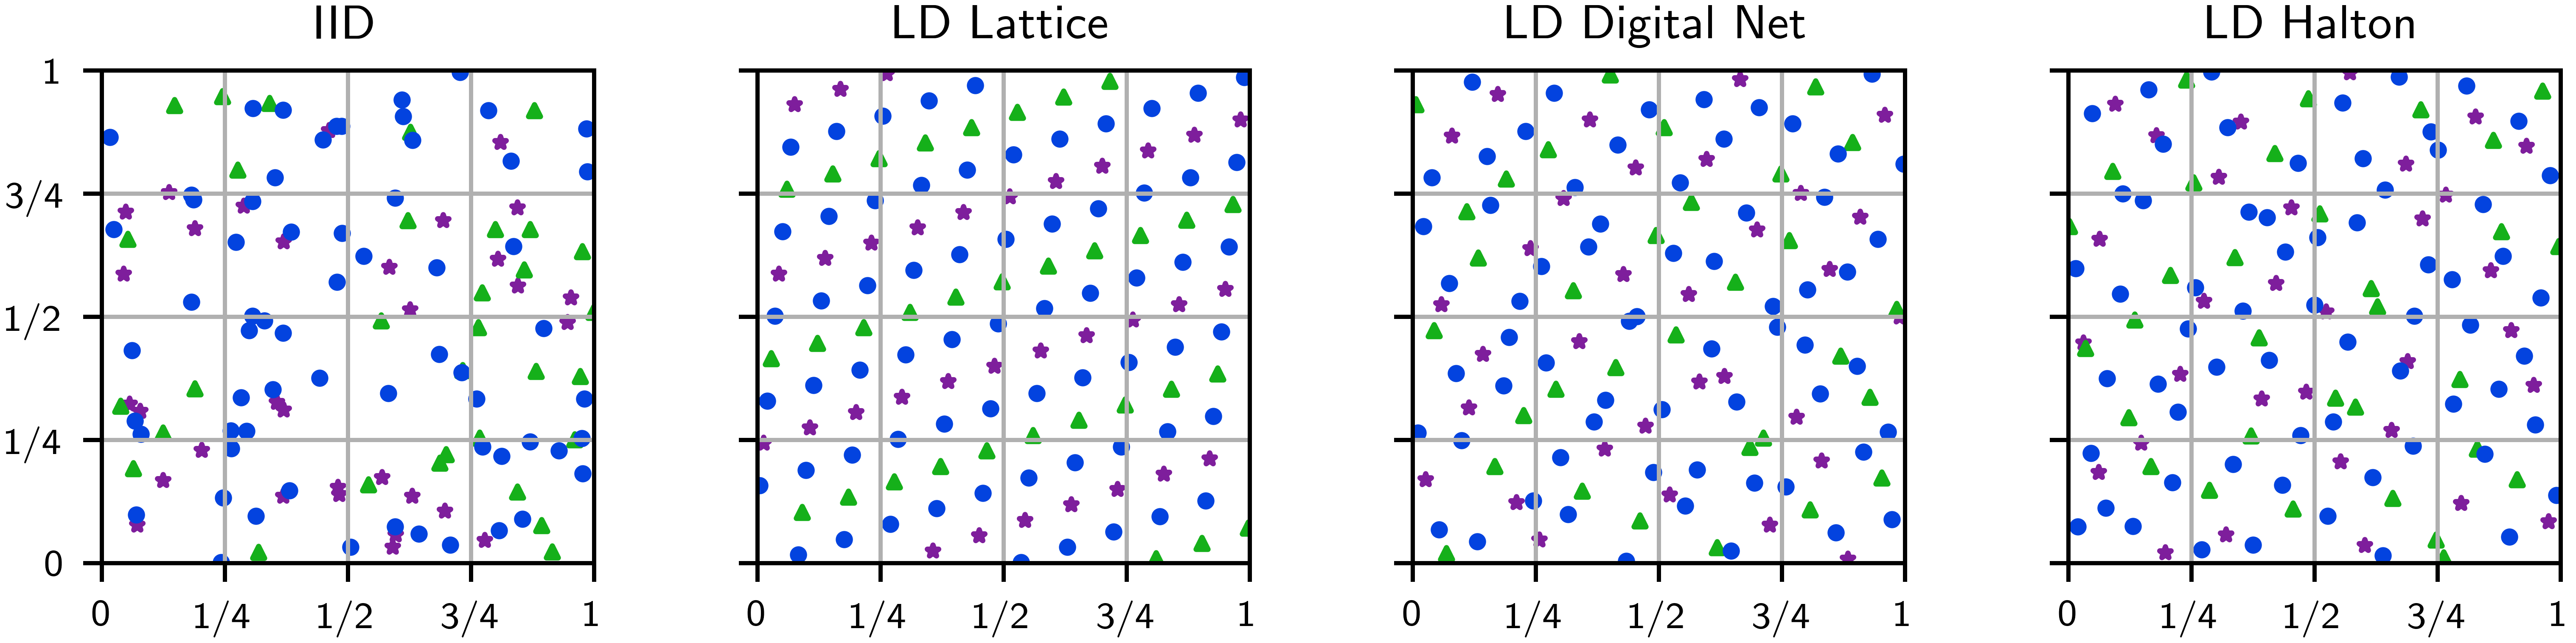

In [9]:
pyplot.rcParams['text.usetex'] = True

ns = np.array([0,2**5,2**6,2**7])
assert len(COLORS)>=(len(ns)-1) and len(MARKERS)>=(len(ns)-1)
nmax = ns.max() 
data = [
    ("IID",qp.IIDStdUniform(2,seed=7)(nmax)),
    ("LD Lattice",qp.Lattice(2,seed=7)(nmax)),
    ("LD Digital Net",qp.DigitalNetB2(2,seed=7,randomize="NUS")(nmax)),
    ("LD Halton",qp.Halton(2,seed=7,randomize="LMS_DS")(nmax)),
]
nrows = 1
ncols = len(data)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,sharey=True,sharex=True,figsize=(FIGWIDTH,FIGWIDTH/ncols))
for i,(name,x) in enumerate(data):
    for j in range(len(ns)-1):
        nmin = ns[j]
        nmax = ns[j+1]
        ax[i].scatter(x[nmin:nmax,0],x[nmin:nmax,1],marker=MARKERS[j],color=COLORS[j],s=MARKERSIZE)
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1/4,1/2,3/4,1]); ax[i].set_xticklabels(["0","1/4","1/2","3/4","1"])
    ax[i].set_yticks([0,1/4,1/2,3/4,1]); ax[i].set_yticklabels(["0","1/4","1/2","3/4","1"])
    ax[i].grid()
    ax[i].set_aspect(1) 
    ax[i].set_title(name)

fig.savefig(OUTDIR+"/points.pdf")
fig.savefig(OUTDIR+"/points.png",dpi=dpi)
fig.savefig(OUTDIR+"/points.svg",transparent=True);

## Convergence

This code performs a comprehensive convergence study comparing Monte Carlo with IID sampling nodes, QMC with Digital Nets and lattices for Asian option pricing. The study evaluates each method across multiple error tolerances and trials to assess their efficiency and accuracy. Results are saved to a file for subsequent analysis and visualization.

In [10]:
tag = "FULL"
force = False
datapath = "%s/%s.npy"%(OUTDIR,tag)
if (not os.path.isfile(datapath)) or force:
    d = 12
    n_init = 2**8
    eps = 10**np.linspace(np.log10(5e-1),np.log10(1e-4),10)
    trials = 100
    with np.printoptions(formatter={"float":lambda x: "%.1e"%x}): print("eps = %s"%str(eps))
    problem = lambda discrete_distrib: \
        qp.FinancialOption(discrete_distrib,
            option = "ASIAN",
            call_put = "CALL",
            asian_mean = "GEOMETRIC",
            asian_mean_quadrature_rule = "RIGHT", 
            volatility = 0.5, 
            start_price = 30., 
            strike_price = 35., 
            interest_rate = 0.01,
            t_final = 1)
    exact_value = problem(qp.IIDStdUniform(d)).get_exact_value()
    print("exact value = %.3f\n"%exact_value)
    algorithms = {
        "MC IID": [1e-2, lambda atol: qp.CubMCG(problem(qp.IIDStdUniform(d)),abs_tol=atol,rel_tol=0,n_init=n_init)], 
        "QMC Digital Net": [0, lambda atol: qp.CubQMCNetG(problem(qp.DigitalNetB2(d)),abs_tol=atol,rel_tol=0,n_init=n_init)],
        "QMC Lattice": [0, lambda atol: qp.CubQMCLatticeG(problem(qp.Lattice(d)),abs_tol=atol,rel_tol=0,n_init=n_init)],
    }
    keys = list(algorithms.keys())
    n_totals = {}
    times = {}
    approxs = {}
    for key,(eps_threshold,sc_constsruct) in algorithms.items():
        print(key)
        n_totals[key] = np.nan*np.ones((len(eps),trials))
        times[key] = np.nan*np.ones((len(eps),trials))
        approxs[key] = np.nan*np.ones((len(eps),trials))
        for j in range(len(eps)):
            if eps[j]<eps_threshold: break
            print("\teps[j] = %.1e"%eps[j])
            for t in range(trials):
                sc = sc_constsruct(eps[j])
                sol,data = sc.integrate()
                approxs[key][j,t] = sol
                n_totals[key][j,t] = data.n_total 
                times[key][j,t] = data.time_integrate
    _data = {
        "eps": eps,
        "n_totals": n_totals,
        "times": times, 
        "approxs": approxs,
        "keys": keys, 
        "exact_value": exact_value,
    }
    np.save(datapath,_data)
else:
    _data = np.load(datapath,allow_pickle=True).item()
    eps = _data["eps"]
    n_totals = _data["n_totals"]
    times = _data["times"]
    approxs = _data["approxs"]
    keys = _data["keys"]
    exact_value = _data["exact_value"]

### Convergence Visualization

This visualization compares three methods—MC IID, QMC Digital Net, and QMC Lattice—across 100 trials for each error tolerance. The figure includes three subplots:

*   **Left Panel - Sample Complexity:** Illustrates the number of samples needed for each error tolerance. Solid lines indicate the median (50th percentile) across trials, while shaded areas represent the inter-decile range (10th to 90th percentiles), showing trial variability. Both axes use a logarithmic scale, with the $x$-axis reversed to highlight lower tolerances on the right. QMC methods require significantly fewer samples than Monte Carlo for equivalent tolerances.

*   **Middle Panel - Computational Time:** Shows the wall-clock time to achieve each error tolerance, using median values and 10th-90th percentile bands.  Both axes are log-scaled with an inverted $x$-axis. QMC methods demonstrate faster convergence than MC IID.

*   **Right Panel - Error Distribution (Violin Plots):** The right panel displays error distributions for a specific tolerance level (eps[jstar], the 5th tolerance). Each method's distribution is represented by a violin plot. The violin shape indicates error probability density across 100 trials; wider sections show more trials within a given error range. Inner box plots display quartiles (25th, 50th, 75th percentiles). The logarithmic $x$-axis accommodates a broad range of error magnitudes. 

    These plots illustrate each method's consistency and reliability. Narrower distributions suggest more predictable performance, while the plot's position indicates the typical error size. Quasi-Monte Carlo (QMC) methods generally exhibit tighter, more consistent error distributions than Monte Carlo (MC) methods. This demonstrates superior average performance and more reliable convergence.


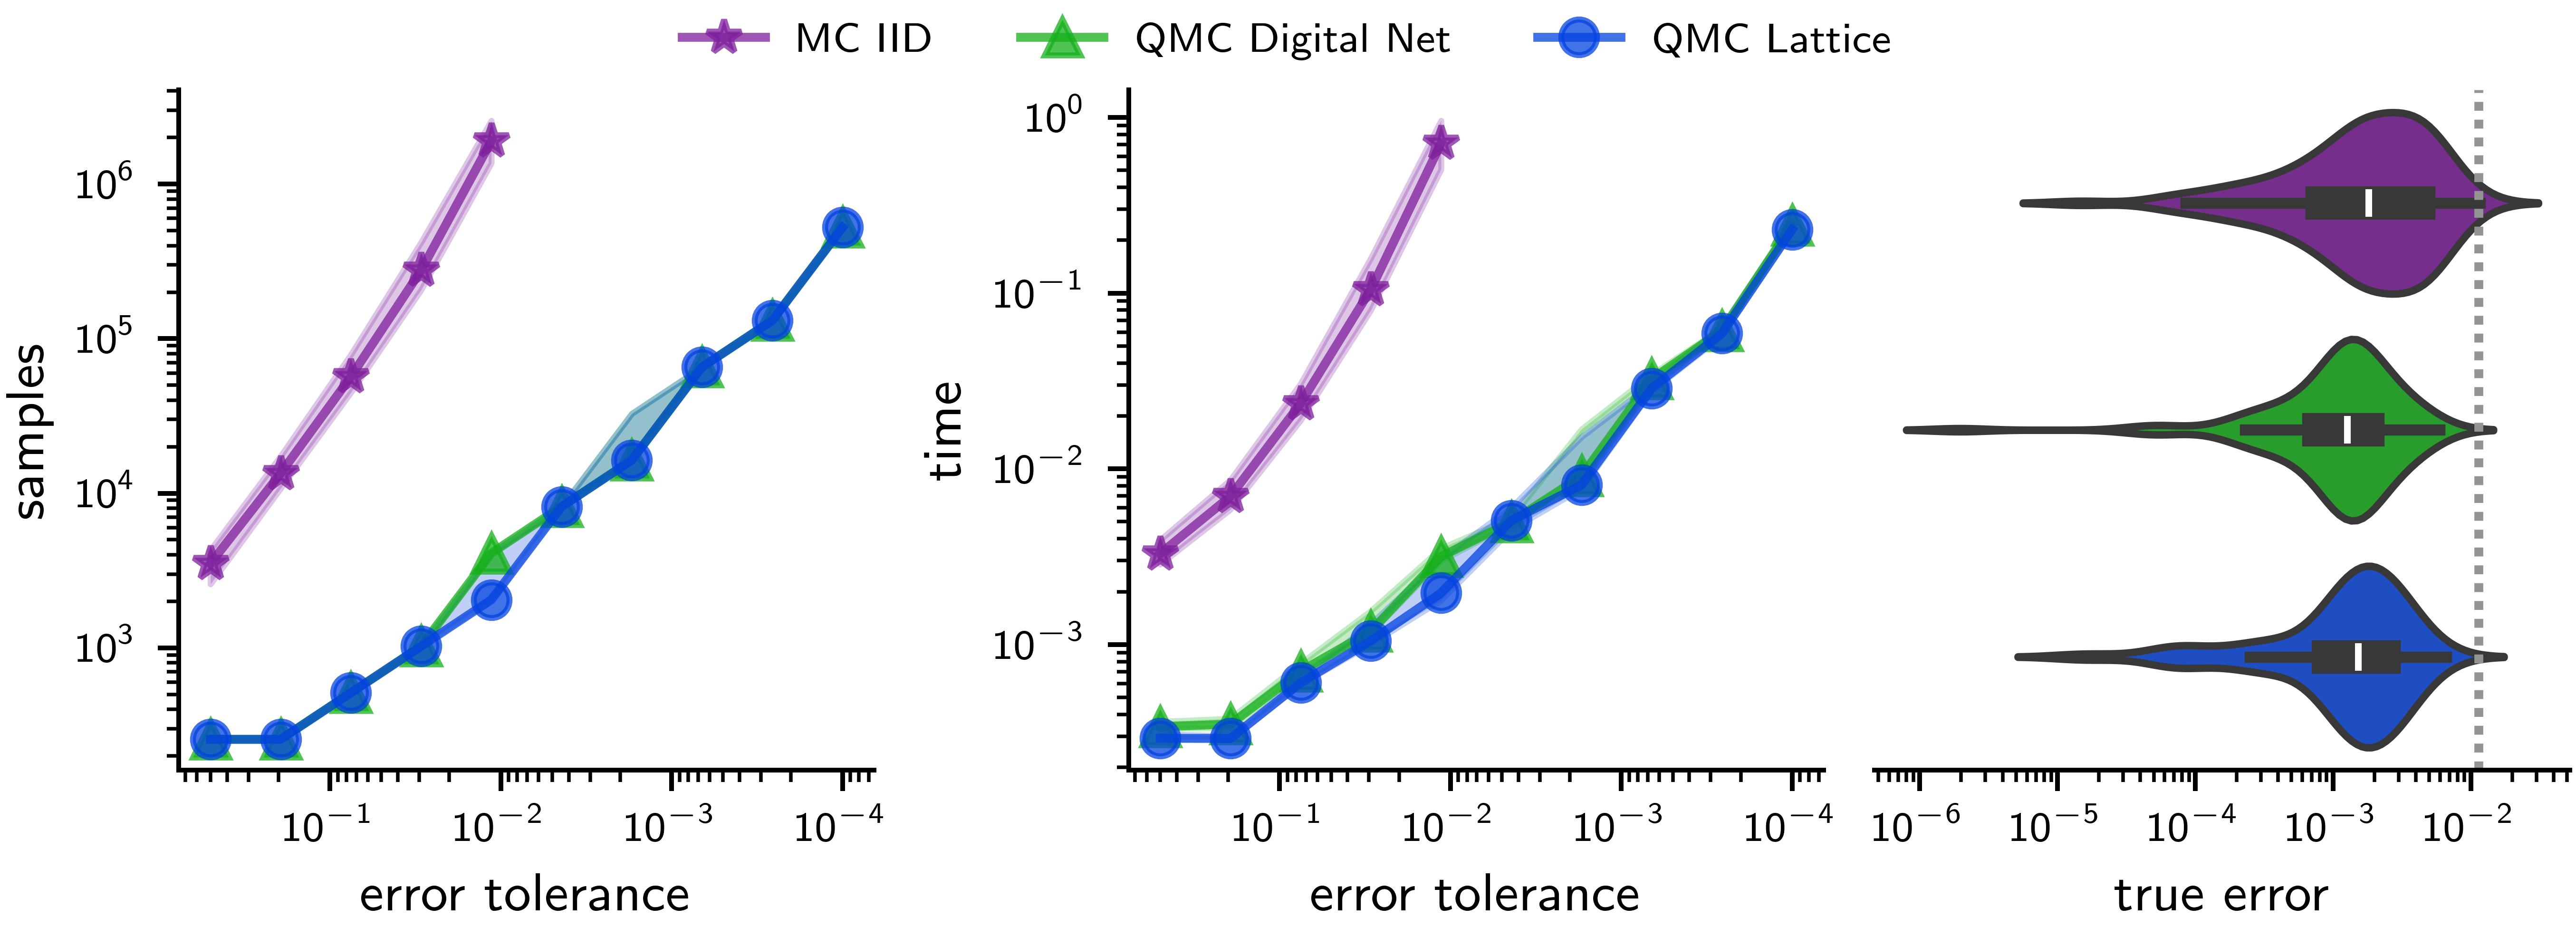

In [11]:
nrows = 1
ncols = 3
alpha = .25
alpha2 = .75
qlow = .1
qhigh = .9
jstar = 4
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(7/8*FIGWIDTH,7/8*FIGWIDTH/ncols),sharey=False,sharex=False)
for i,key in enumerate(keys):
    n_total = n_totals[key] 
    time = times[key]
    approx = approxs[key]
    color = COLORS[i]
    ax[0].plot(eps,np.quantile(n_total,.5,axis=1),label=key,color=color,marker=MARKERS[i],alpha=alpha2)
    ax[0].fill_between(eps,np.quantile(n_total,qlow,axis=1),np.quantile(n_total,qhigh,axis=1),color=color,alpha=alpha)
    ax[1].plot(eps,np.quantile(time[:,:],.5,axis=1),color=color,marker=MARKERS[i],alpha=alpha2)
    ax[1].fill_between(eps,np.quantile(time,qlow,axis=1),np.quantile(time,qhigh,axis=1),color=color,alpha=alpha)
errors = np.stack([np.abs(exact_value-approxs[key][jstar]) for key in keys],axis=1)
sns.violinplot(data=errors,ax=ax[2],log_scale=True,orient="h",palette=COLORS[:len(keys)],inner="box")
for i in range(2):
    ax[i].set_xscale("log",base=10) 
    ax[i].set_yscale("log",base=10)
    ax[i].set_xlabel("error tolerance")
    ax[i].xaxis.set_inverted(True)
for i in range(3):
    for spine in ["top","right"]: ax[i].spines[spine].set_visible(False)
ax[2].axvline(eps[jstar],color="xkcd:gray",linestyle=(0,(1,1)))
ax[0].set_ylabel("samples")
ax[1].set_ylabel("time")
ax[2].set_xlabel("true error")
ax[2].get_yaxis().set_visible(False)
ax[2].spines["left"].set_visible(False)
fig.legend(frameon=False,loc="upper center",ncols=4,bbox_to_anchor=(.5,1.1))
fig.savefig(OUTDIR+"/stopping_crit.pdf",bbox_inches='tight')
fig.savefig(OUTDIR+"/stopping_crit.png",dpi=dpi,bbox_inches='tight')
fig.savefig(OUTDIR+"/stopping_crit.svg",transparent=True,bbox_inches='tight');